        IMPORTS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

        Step 1: Load and Preprocess Data

In [3]:

btc_data = pd.read_csv('btc_price_hourly.csv', parse_dates=['Datetime'])


btc_data.set_index('Datetime', inplace=True)
# iota_data.set_index('timestamp', inplace=True)


btc_daily = btc_data.resample('D').agg({
    'Close': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).dropna()



btc_daily['median'] = btc_daily[['High', 'Low']].median(axis=1)
btc_daily['average'] = btc_daily[['High', 'Low']].mean(axis=1)



assert btc_daily.isna().sum().sum() == 0, "BTC data contains missing values!"
# assert iota_daily.isna().sum().sum() == 0, "IOTA data contains missing values!"

btc_daily.head()


,Close,High,Low,median,average
Datetime,,,,,
2024-09-13 00:00:00+00:00,60593.835938,60640.191406,57658.730469,59149.460938,59149.460938
2024-09-14 00:00:00+00:00,60004.453125,60645.542969,59541.289062,60093.416016,60093.416016
2024-09-15 00:00:00+00:00,59188.644531,60377.878906,58734.300781,59556.089844,59556.089844
2024-09-16 00:00:00+00:00,58189.855469,59195.609375,57526.574219,58361.091797,58361.091797
2024-09-17 00:00:00+00:00,60326.382812,61289.640625,57643.332031,59466.486328,59466.486328


## Step 2: Exploratory Data Analysis (EDA)

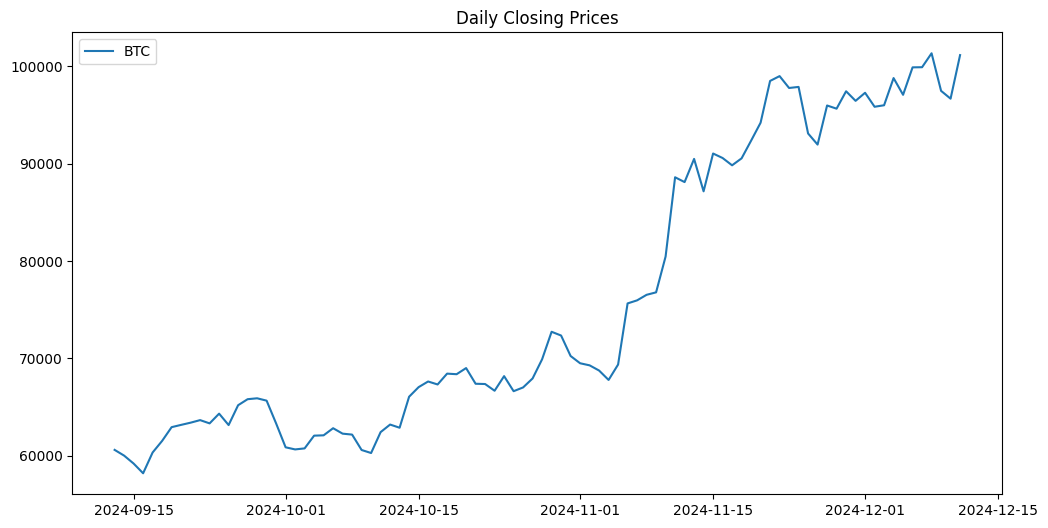

ADF Statistic for BTC Close: 0.09548550536627377
p-value: 0.9657515135344602
BTC Close series is not stationary.


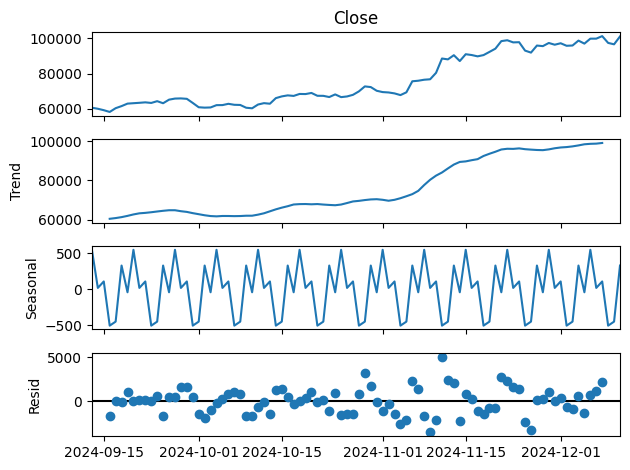

In [4]:

plt.figure(figsize=(12, 6))
plt.plot(btc_daily['Close'], label='BTC')
# plt.plot(iota_daily['close'], label='IOTA')
plt.title("Daily Closing Prices")
plt.legend()
plt.show()


def adf_test(series, label):
    result = adfuller(series)
    print(f"ADF Statistic for {label}: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print(f"{label} series is stationary.")
    else:
        print(f"{label} series is not stationary.")

adf_test(btc_daily['Close'], "BTC Close")


btc_decompose = seasonal_decompose(btc_daily['Close'], model='additive')
btc_decompose.plot()
plt.show()


*******************************************************


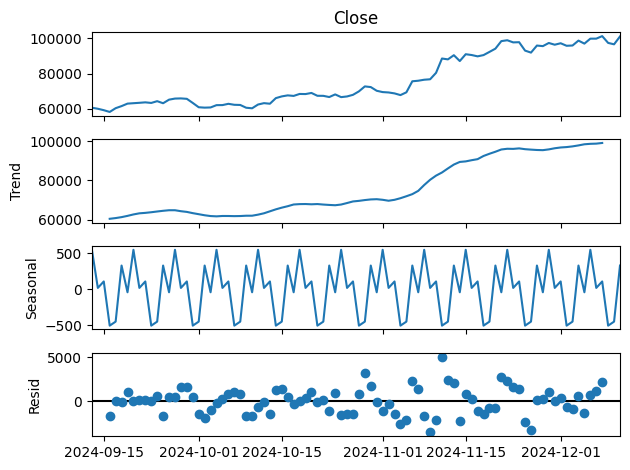

In [5]:

additive_decompose = seasonal_decompose(btc_daily['Close'], model='additive')
additive_decompose.plot()
print("*******************************************************")

multiplicative_decompose = seasonal_decompose(btc_daily['Close'], model='multiplicative')
# multiplicative_decompose.plot()

In [6]:

additive_resid_var = additive_decompose.resid.var()
multiplicative_resid_var = multiplicative_decompose.resid.var()

print("Variance of Additive Residuals:", additive_resid_var)
print("Variance of Multiplicative Residuals:", multiplicative_resid_var)


Variance of Additive Residuals: 2315609.501123142
Variance of Multiplicative Residuals: 0.0003827900646022744


### Step 3: Make the Series Stationary

In [7]:

btc_daily['close_diff'] = btc_daily['Close'].diff().dropna()

adf_test(btc_daily['close_diff'].dropna(), "BTC Close (Differenced)")


ADF Statistic for BTC Close (Differenced): -8.901859540238291
p-value: 1.1655512132721032e-14
BTC Close (Differenced) series is stationary.


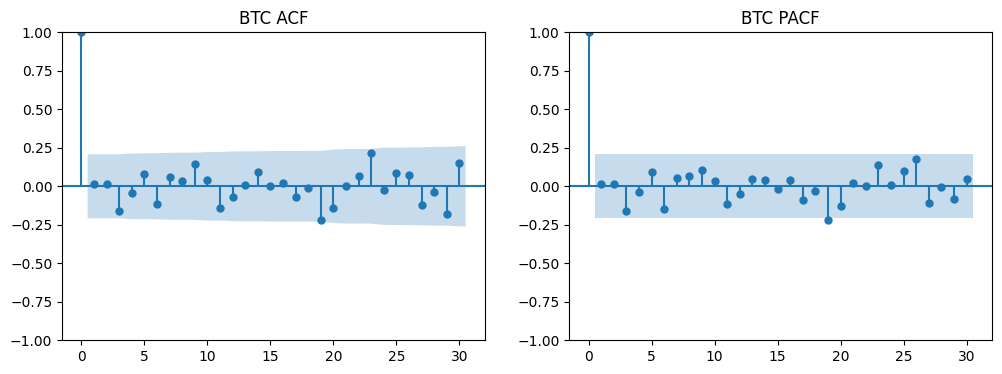

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   90
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -815.019
Date:                Fri, 13 Dec 2024   AIC                           1638.038
Time:                        18:39:09   BIC                           1648.037
Sample:                    09-13-2024   HQIC                          1642.070
                         - 12-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.601e+04   2.37e+04      3.212      0.001    2.96e+04    1.22e+05
ar.L1          0.9934      0.018     55.333      0.000       0.958       1.029
ma.L1          0.0596      0.108      0.552      0.5

In [8]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(btc_daily['close_diff'].dropna(), ax=axes[0], title='BTC ACF',lags=30)
plot_pacf(btc_daily['close_diff'].dropna(), ax=axes[1], title='BTC PACF',lags=30)
plt.show()


btc_model = ARIMA(btc_daily['Close'], order=(1, 0, 1))
btc_fit = btc_model.fit()

print(btc_fit.summary())

## Step 5: Evaluate and Forecast

        ARIMA(1,0,1)

c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model - MSE: 3137625.2013610275
Model - MAE: 1421.396123909957
Model - RMSE: 1771.3342997190077
Model - R²: 0.050431777670916667
Model - MAPE: 0.014337041074472343


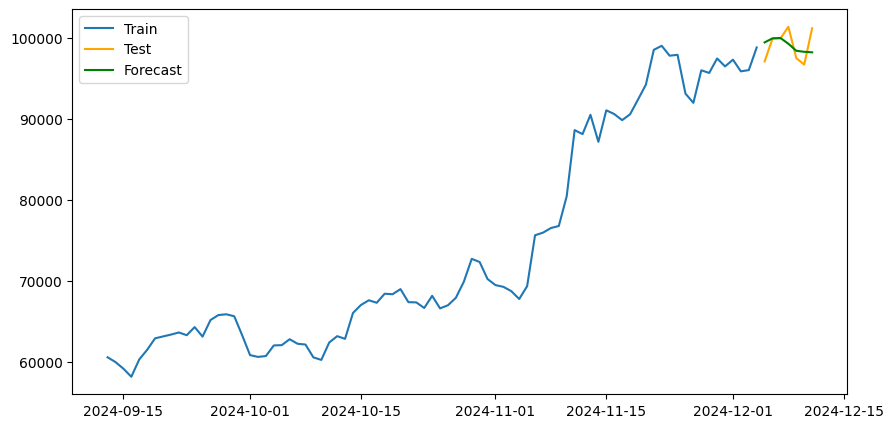

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

train = btc_daily['Close'][:-7]
test = btc_daily['Close'][-7:]

btc_model = ARIMA(train, order=(20, 1, 7))
btc_fit = btc_model.fit()


forecast = btc_fit.forecast(steps=7)
forecast.index = test.index
mse_arima = mean_squared_error(test, forecast)
mae_arima = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse_arima)
r2 = r2_score(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)

print(f"Model - MSE: {mse_arima}")
print(f"Model - MAE: {mae_arima}")
print(f"Model - RMSE: {rmse}")
print(f"Model - R²: {r2}")
print(f"Model - MAPE: {mape}")

plt.figure(figsize=(10, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(forecast, label='Forecast', color='green')
plt.legend()
plt.show()

        ARIMA Grid Search

In [10]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error

# def arima_grid_search(series, p_values, d_values, q_values):
#     best_score, best_params = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 try:
#                     model = ARIMA(series, order=(p, d, q))
#                     model_fit = model.fit()
#                     aic = model_fit.aic
#                     if aic < best_score:
#                         best_score, best_params = aic, (p, d, q)
#                 except:
#                     continue
#     return best_params, best_score



# series = btc_daily['close_diff']
# p_values = range(0, 20) 
# d_values = range(0, 2)  
# q_values = range(0, 20)  

# best_arima_params, best_aic = arima_grid_search(series, p_values, d_values, q_values)
# print(f"Best ARIMA params: {best_arima_params} with AIC: {best_aic}")


        Exponential Smoothing (ETS)

c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


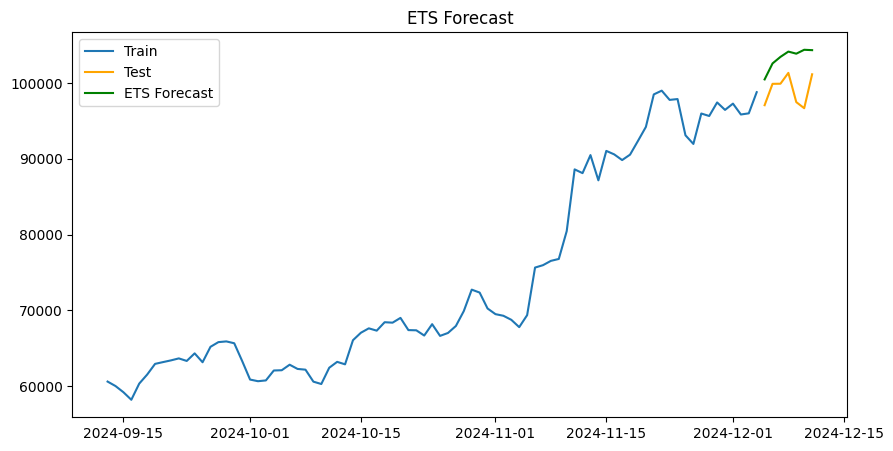

ETS - Mean Squared Error: 21408806.681155305, Mean Absolute Error: 4249.670553194731


In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


train = btc_daily['Close'][:-7]
test = btc_daily['Close'][-7:]


ets_model = ExponentialSmoothing(
    train, 
    seasonal='mul', 
    trend='mul', 
    seasonal_periods=7 
).fit()


ets_forecast = ets_model.forecast(steps=7)
ets_forecast.index = test.index


plt.figure(figsize=(10, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(ets_forecast, label='ETS Forecast', color='green')
plt.legend()
plt.title("ETS Forecast")
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_ets = mean_squared_error(test, ets_forecast)
mae_ets = mean_absolute_error(test, ets_forecast)
print(f"ETS - Mean Squared Error: {mse_ets}, Mean Absolute Error: {mae_ets}")


c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


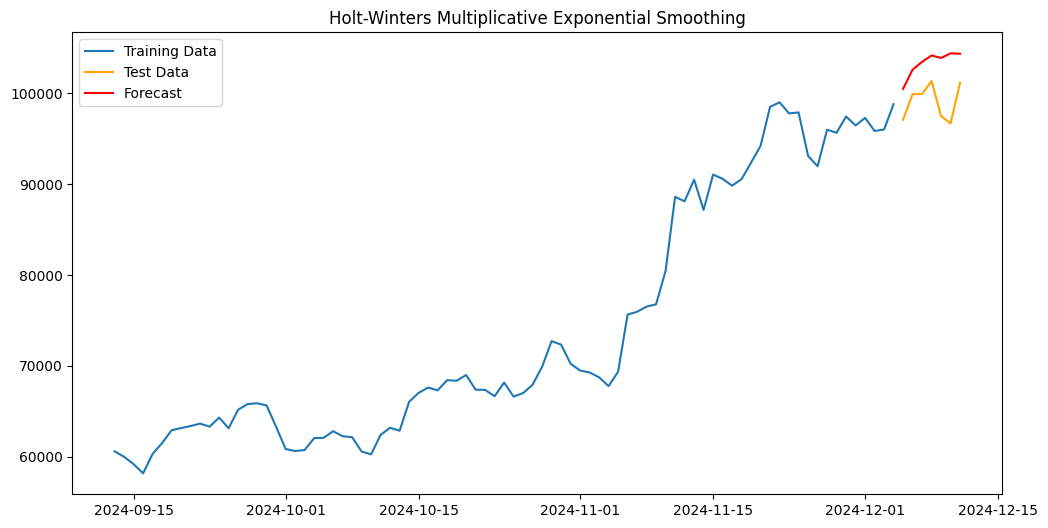

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


ets_model = ExponentialSmoothing(
    train, 
    trend='mul',         
    seasonal='mul',     
    seasonal_periods=7   
).fit()


forecast = ets_model.forecast(steps=7)  


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data', color='orange')  #
plt.plot(forecast, label='Forecast', color='red')
plt.title('Holt-Winters Multiplicative Exponential Smoothing')
plt.legend()
plt.show()


        SARIMA

Identify Seasonal Parameters (𝑃, 𝐷, 𝑄, 𝑠)


Seasonal Period 𝑠

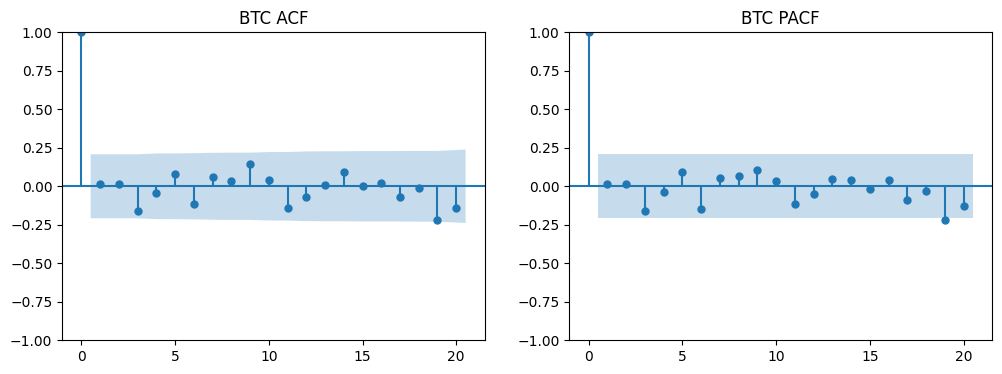

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF to identify seasonality
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(btc_daily['close_diff'].dropna(),lags=20, ax=axes[0], title='BTC ACF')
plot_pacf(btc_daily['close_diff'].dropna(), lags=20,ax=axes[1], title='BTC PACF')
plt.show()


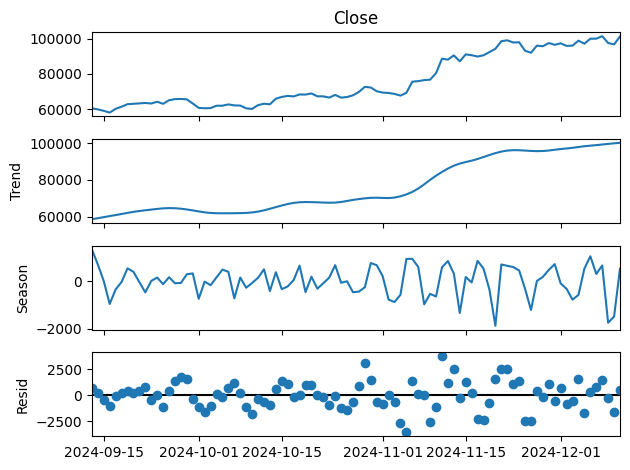

In [14]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(btc_daily['Close'], period=6)  # Start with 24-hour seasonality as a guess
result = stl.fit()

# Plot the decomposition
result.plot()
plt.show()


In [15]:
from statsmodels.tsa.stattools import adfuller

# Seasonal differencing
s = 7  # Example: Daily seasonality for hourly data
btc_daily['seasonal_diff'] = btc_daily['Close'] - btc_daily['Close'].shift(s)
result = adfuller(btc_daily['seasonal_diff'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value < 0.05, the data is stationary, suggesting D = 1


ADF Statistic: -1.604607083494692
p-value: 0.48127880158535585


In [16]:
# Differencing
btc_daily['seasonal_diff'] = btc_daily['seasonal_diff'].diff().dropna()
# iota_daily['close_diff'] = iota_daily['close'].diff().dropna()

adf_test(btc_daily['seasonal_diff'].dropna(), "Seasonal differencing")

ADF Statistic for Seasonal differencing: -5.850842743870408
p-value: 3.592480105713106e-07
Seasonal differencing series is stationary.


c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\ocp ms\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


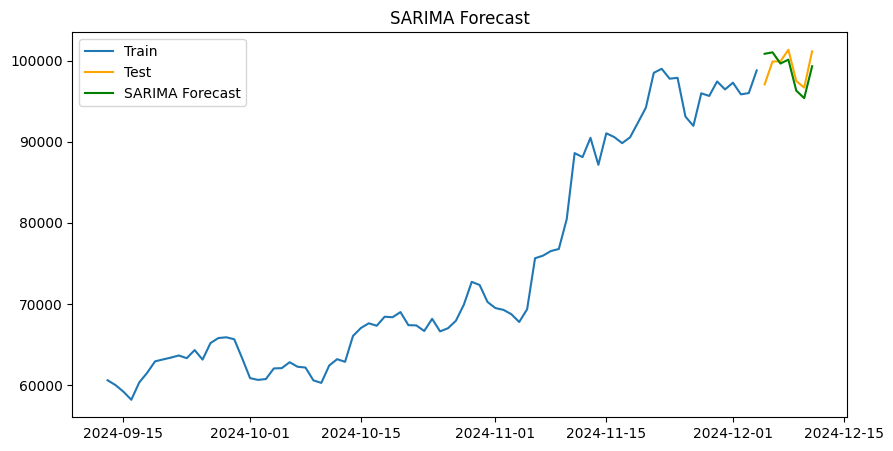

Model - MSE: 3361625.5995972552
Model - MAE: 1529.304814580884
Model - RMSE: 1833.4736430058806
Model - R²: -0.01735951233463129
Model - MAPE: 0.015511086272469773
SARIMA - Mean Squared Error: 3361625.5995972552, Mean Absolute Error: 1529.304814580884


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train = btc_daily['Close'][:-7]
test = btc_daily['Close'][-7:]


sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(5, 2, 5, 7))
sarima_fit = sarima_model.fit(disp=False)


sarima_forecast = sarima_fit.forecast(steps=7)
sarima_forecast.index = test.index


plt.figure(figsize=(10, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(sarima_forecast, label='SARIMA Forecast', color='green')
plt.legend()
plt.title("SARIMA Forecast")
plt.show()


mse_sarima = mean_squared_error(test, sarima_forecast)
mae_sarima = mean_absolute_error(test, sarima_forecast)


mse_arima = mean_squared_error(test, sarima_forecast)
mae_arima = mean_absolute_error(test, sarima_forecast)
rmse = np.sqrt(mse_arima)
r2 = r2_score(test, sarima_forecast)
mape = mean_absolute_percentage_error(test, sarima_forecast)

print(f"Model - MSE: {mse_arima}")
print(f"Model - MAE: {mae_arima}")
print(f"Model - RMSE: {rmse}")
print(f"Model - R²: {r2}")
print(f"Model - MAPE: {mape}")
print(f"SARIMA - Mean Squared Error: {mse_sarima}, Mean Absolute Error: {mae_sarima}")


        Prophet

In [18]:
btc_daily['Close']

Datetime
2024-09-13 00:00:00+00:00     60593.835938
2024-09-14 00:00:00+00:00     60004.453125
2024-09-15 00:00:00+00:00     59188.644531
2024-09-16 00:00:00+00:00     58189.855469
2024-09-17 00:00:00+00:00     60326.382812
                                 ...      
2024-12-07 00:00:00+00:00     99914.656250
2024-12-08 00:00:00+00:00    101346.710938
2024-12-09 00:00:00+00:00     97485.726562
2024-12-10 00:00:00+00:00     96681.914062
2024-12-11 00:00:00+00:00    101160.039062
Freq: D, Name: Close, Length: 90, dtype: float64

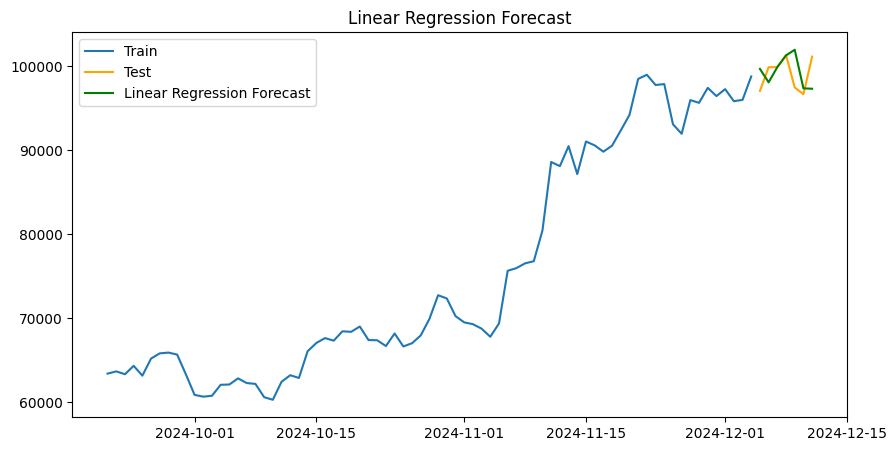

Linear Regression - Mean Squared Error: 6483732.65441603, Mean Absolute Error: 1925.6354002254977


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


for lag in range(1, 8):
    btc_daily[f'lag_{lag}'] = btc_daily['Close'].shift(lag)


btc_lagged = btc_daily.dropna()


X = btc_lagged[[f'lag_{i}' for i in range(1, 8)]]
y = btc_lagged['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7, shuffle=False)


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


lr_forecast = lr_model.predict(X_test)


plt.figure(figsize=(10, 5))
plt.plot(y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test', color='orange')
plt.plot(y_test.index, lr_forecast, label='Linear Regression Forecast', color='green')
plt.legend()
plt.title("Linear Regression Forecast")
plt.show()


mse_lr = mean_squared_error(y_test, lr_forecast)
mae_lr = mean_absolute_error(y_test, lr_forecast)
print(f"Linear Regression - Mean Squared Error: {mse_lr}, Mean Absolute Error: {mae_lr}")

In [22]:
results = {
    'Model': ['ETS', 'SARIMA', 'Linear Regression'],
    'MSE': [mse_ets, mse_sarima, mse_lr],
    'MAE': [mae_ets, mae_sarima, mae_lr]
}

results_df = pd.DataFrame(results)
print(results_df)


               Model           MSE          MAE
0                ETS  2.140881e+07  4249.670553
1             SARIMA  3.361626e+06  1529.304815
2  Linear Regression  6.483733e+06  1925.635400


Epoch 1/5000
3/3 [==============================] - 3s 8ms/step - loss: 0.0954
Epoch 2/5000
3/3 [==============================] - 0s 6ms/step - loss: 0.0742
Epoch 3/5000
3/3 [==============================] - 0s 6ms/step - loss: 0.0608
Epoch 4/5000
3/3 [==============================] - 0s 7ms/step - loss: 0.0486
Epoch 5/5000
3/3 [==============================] - 0s 7ms/step - loss: 0.0394
Epoch 6/5000
3/3 [==============================] - 0s 6ms/step - loss: 0.0317
Epoch 7/5000
3/3 [==============================] - 0s 6ms/step - loss: 0.0254
Epoch 8/5000
3/3 [==============================] - 0s 7ms/step - loss: 0.0212
Epoch 9/5000
3/3 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 10/5000
3/3 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 11/5000
3/3 [==============================] - 0s 6ms/step - loss: 0.0133
Epoch 12/5000
3/3 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 13/5000
3/3 [==============================

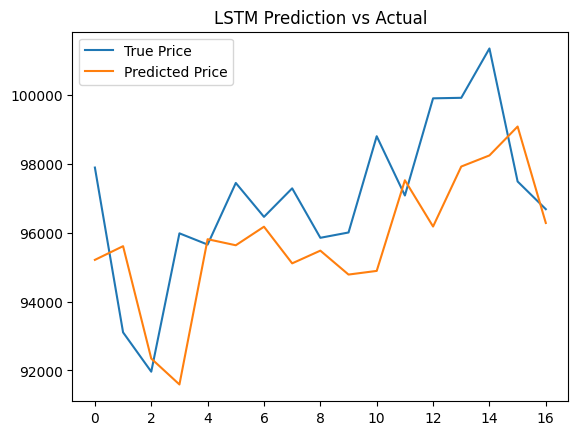

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense




btc_lstm = btc_daily[['Close']].reset_index()
btc_lstm.columns = ['ds', 'y']


scaler = MinMaxScaler(feature_range=(0, 1))
btc_lstm_scaled = scaler.fit_transform(btc_lstm[['y']])


def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 7
X, y = create_dataset(btc_lstm_scaled, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


model = Sequential()
model.add(LSTM(units=25, return_sequences=False, input_shape=(time_step, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train, y_train, epochs=5000, batch_size=32)


predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_lstm = mean_squared_error(y_test_scaled, predictions)
mae_lstm = mean_absolute_error(y_test_scaled, predictions)

print(f"LSTM - Mean Squared Error: {mse_lstm}, Mean Absolute Error: {mae_lstm}")


plt.plot(y_test_scaled, label='True Price')
plt.plot(predictions, label='Predicted Price')
plt.legend()
plt.title("LSTM Prediction vs Actual")
plt.show()


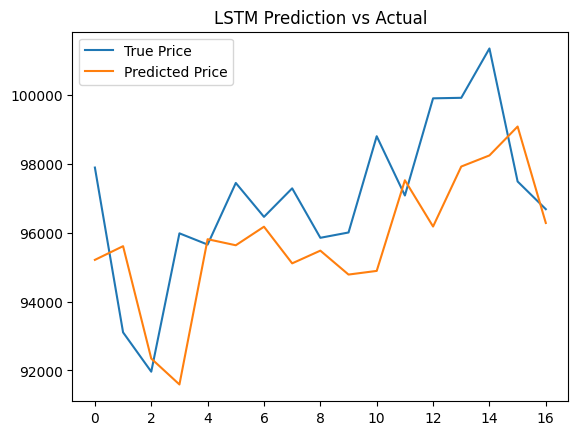

In [24]:

full_series = np.zeros_like(btc_lstm_scaled[:, 0])
full_series[:] = np.nan
full_series[train_size + time_step:len(predictions) + train_size + time_step] = predictions.flatten()


btc_original = scaler.inverse_transform(btc_lstm_scaled)
train_original = btc_original[:train_size]
test_original = btc_original[train_size + time_step:]
test_original_shifted = btc_lstm_scaled


plt.plot(y_test_scaled, label='True Price')
plt.plot(predictions, label='Predicted Price')
plt.legend()
plt.title("LSTM Prediction vs Actual")
plt.show()

Random Forest - Mean Squared Error: 5875205.315876181, Mean Absolute Error: 1972.1980909926463


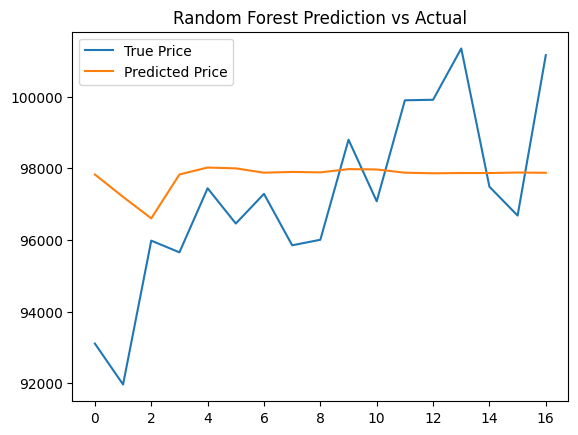

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


btc_rf = btc_lstm.copy()
for i in range(1, 8):
    btc_rf[f'lag_{i}'] = btc_rf['y'].shift(i)

btc_rf = btc_rf.dropna()

X_rf = btc_rf.drop(columns=['ds', 'y'])
y_rf = btc_rf['y']


X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, shuffle=False)


rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)


rf_predictions = rf_model.predict(X_test_rf)


mse_rf = mean_squared_error(y_test_rf, rf_predictions)
mae_rf = mean_absolute_error(y_test_rf, rf_predictions)

print(f"Random Forest - Mean Squared Error: {mse_rf}, Mean Absolute Error: {mae_rf}")


plt.plot(y_test_rf.values, label='True Price')
plt.plot(rf_predictions, label='Predicted Price')
plt.legend()
plt.title("Random Forest Prediction vs Actual")
plt.show()

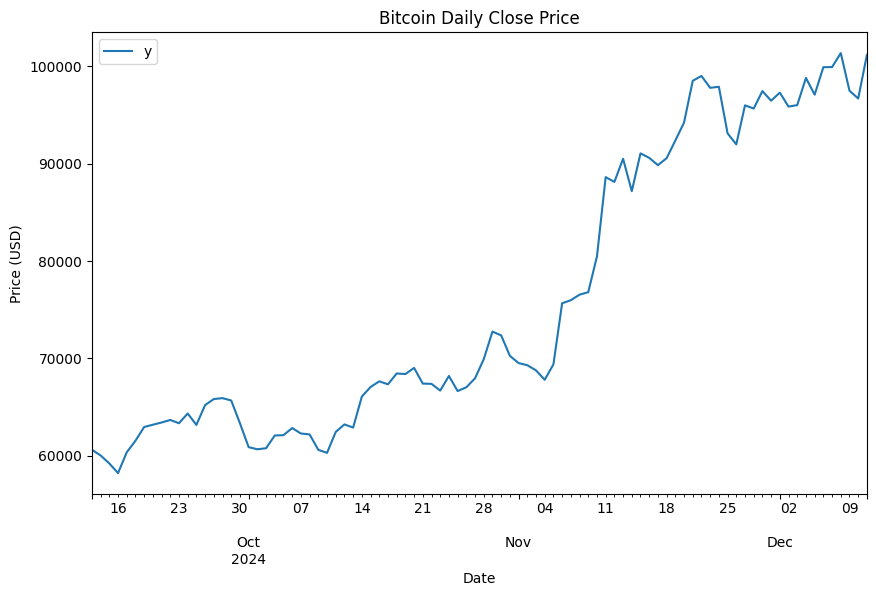

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error


btc_data = pd.read_csv('btc_price_hourly.csv', parse_dates=['Datetime'])

btc_data.set_index('Datetime', inplace=True)


btc_daily = btc_data.resample('D').agg({
    'Close': 'last'  
}).dropna()


btc_prophet = btc_daily[['Close']].reset_index()
btc_prophet.columns = ['ds', 'y']  


btc_prophet.set_index('ds').plot(figsize=(10, 6))
plt.title("Bitcoin Daily Close Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

        BENCHMARKING

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

predictions_lstm = model.predict(X_test)

predictions_lstm = scaler.inverse_transform(predictions_lstm)


y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


mse_lstm = mean_squared_error(y_test_scaled, predictions_lstm)
mae_lstm = mean_absolute_error(y_test_scaled, predictions_lstm)
rmse_lstm = np.sqrt(mse_lstm) 
r2_lstm = r2_score(y_test_scaled, predictions_lstm)  
mape_lstm = mean_absolute_percentage_error(y_test_scaled, predictions_lstm)  


print(f"LSTM Model - MSE: {mse_lstm}")
print(f"LSTM Model - MAE: {mae_lstm}")
print(f"LSTM Model - RMSE: {rmse_lstm}")
print(f"LSTM Model - R²: {r2_lstm}")
print(f"LSTM Model - MAPE: {mape_lstm}")


1/1 [==============================] - 0s 41ms/step
LSTM Model - MSE: 5190169.485574149
LSTM Model - MAE: 1831.7371323529394
LSTM Model - RMSE: 2278.1943476301904
LSTM Model - R²: -0.021107162775472643
LSTM Model - MAPE: 0.018748272961316845
